In [1]:
# from tensorflow.keras.utils import plot_model
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Add, Dense, Activation,\
     Flatten, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import *
import tensorflow as tf

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [4]:
train_images = train_images/255.0
test_images = test_images/255.0

In [5]:
w, h = 32, 32
train_images = train_images.reshape(train_images.shape[0], w, h, 3)
test_images = test_images.reshape(test_images.shape[0], w, h, 3)

In [6]:
train_images.shape

(50000, 32, 32, 3)

In [7]:
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [8]:
classess = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [9]:
def Structure(X):
    conv1 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X)
    conv1 = Conv2D(32, 2, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.2)(pool1)
    conv2 = Conv2D(64, 2, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 2, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.3)(pool2)
    conv3 = Conv2D(128, 2, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 2, activation='relu', padding='same')(conv3)
    # conv3 = Conv2D(64, 2, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # X = Conv2D(256, 3, activation='relu', padding='same')(X)
    # X = Conv2D(256, 3, activation='relu', padding='same')(X)
    # X = Conv2D(256, 3, activation='relu', padding='same')(X)
    # X = MaxPooling2D(pool_size=(2, 2))(X)
    # X = Conv2D(128, 3, activation='relu', padding='same')(X)
    # X = Conv2D(128, 3, activation='relu', padding='same')(X)
    # X = Conv2D(128, 3, activation='relu', padding='same')(X)
    # X = MaxPooling2D(pool_size=(2, 2))(X)
    # X = UpSampling2D(size=(2, 2))(X)
    # X = Conv2D(128, 3, activation='relu', padding='same')(X)
    # X = Conv2D(128, 3, activation='relu', padding='same')(X)
    # X = Conv2D(128, 3, activation='relu', padding='same')(X)   
    # X = UpSampling2D(size=(2, 2))(X)
    # X = Conv2D(256, 3, activation='relu', padding='same')(X)
    # X = Conv2D(256, 3, activation='relu', padding='same')(X)
    # X = Conv2D(256, 3, activation='relu', padding='same')(X)   
    up1 = UpSampling2D(size=(2, 2))(pool3)
    up1 = concatenate([conv3, up1], axis=-1)
    conv4 = Conv2D(128, 2, activation='relu', padding='same')(up1)
    # conv4 = Conv2D(64, 3, activation='relu', padding='same')(conv4)
    conv4 = Conv2D(128, 2, activation='relu', padding='same')(conv4)   
    conv4 = Dropout(0.3)(conv4)
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv2, up2], axis=-1)
    conv5 = Conv2D(64, 2, activation='relu', padding='same')(up2)
    conv5 = Conv2D(64, 2, activation='relu', padding='same')(conv5)
    conv5 = Dropout(0.2)(conv5)
    up3 = UpSampling2D(size=(2, 2))(conv5)
    up3 = concatenate([conv1, up3], axis=-1)
    conv6 = Conv2D(32, 2, activation='relu', padding='same')(up3)
    conv6 = Conv2D(32, 2, activation='relu', padding='same')(conv6)
    return conv6

In [10]:
def UNET(input_shape = (w, h, 3), classes = classess):
    X_input = Input(shape = input_shape)
    X = Structure(X_input)
    X = Conv2D(len(classes), 1, activation = 'softmax')(X)
    X = Flatten()(X)
    X = Dense(len(classess), activation='softmax')(X)
    model = Model(inputs = X_input, outputs = X, name = 'U-net')
    return model

In [11]:
#Clear unnecessary memory
from tensorflow.keras import backend as K
import tensorflow as tf
K.clear_session()

In [12]:
model = UNET(input_shape = (w, h, 3), classes = classess)
model.summary()

Model: "U-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   416         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   4128        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Unet-cifar10.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataUnetcifar10.csv"),
    TensorBoard(log_dir='./logs-Unet-Cifar', histogram_freq=1)
]

In [14]:
# Compile the model
model.compile(optimizer = 'adam',
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
history = model.fit(train_images, 
                    train_labels,
                    batch_size = 256,
                    validation_split=0.15,
                    epochs = 100,
                    shuffle = True,
                    callbacks= callbacks)

Epoch 1/100
167/167 [==============================] - 14s 52ms/step - loss: 1.9844 - accuracy: 0.2719 - val_loss: 2.0960 - val_accuracy: 0.2629

Epoch 00001: val_loss improved from inf to 2.09604, saving model to model-Unet-cifar10.h5
Epoch 2/100
167/167 [==============================] - 8s 47ms/step - loss: 1.5979 - accuracy: 0.4201 - val_loss: 2.1137 - val_accuracy: 0.3265

Epoch 00002: val_loss did not improve from 2.09604
Epoch 3/100
167/167 [==============================] - 8s 47ms/step - loss: 1.4362 - accuracy: 0.4863 - val_loss: 1.3661 - val_accuracy: 0.5024

Epoch 00003: val_loss improved from 2.09604 to 1.36613, saving model to model-Unet-cifar10.h5
Epoch 4/100
167/167 [==============================] - 8s 47ms/step - loss: 1.2900 - accuracy: 0.5376 - val_loss: 1.3493 - val_accuracy: 0.5268

Epoch 00004: val_loss improved from 1.36613 to 1.34929, saving model to model-Unet-cifar10.h5
Epoch 5/100
167/167 [==============================] - 8s 48ms/step - loss: 1.1863 - accur

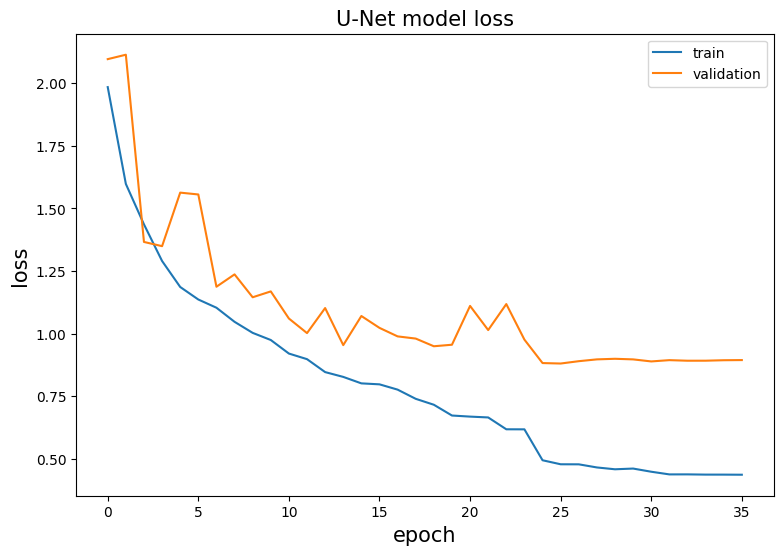

In [16]:
# Loss
plt.figure(figsize = (9, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('U-Net model loss', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.xlabel('epoch', fontsize = 15)
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

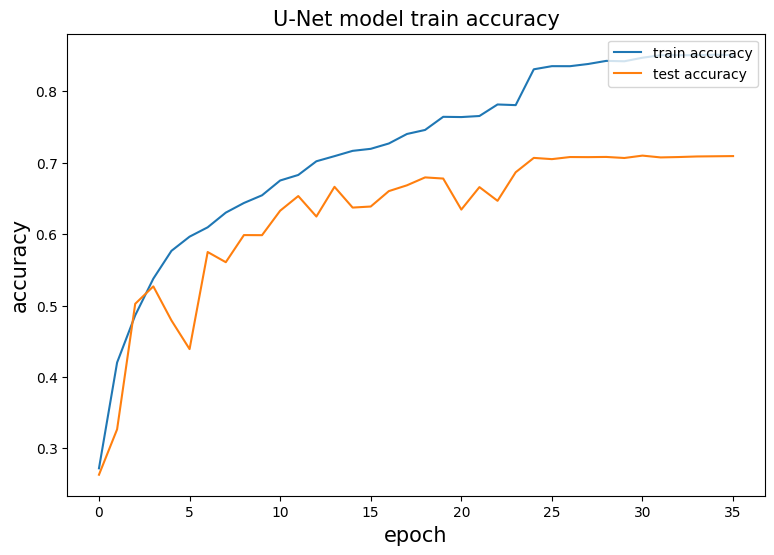

In [17]:
# Accuracy
plt.figure(figsize = (9, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('U-Net model train accuracy', fontsize = 15)
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('accuracy', fontsize = 15)
plt.legend(['train accuracy', 'test accuracy'], loc = 'upper right')
plt.show()

In [18]:
# Evaluating the model using the test set
# loss, accuracy, sparse = model.evaluate(test_images, test_labels, verbose = 1)
# print('\nTest accuracy:', accuracy)

In [19]:
predictions = model.predict(test_images)

In [20]:
classess_text = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',\
         'frog', 'horse', 'ship', 'truck']

In [21]:
train_images = train_images.reshape(train_images.shape[0], w, h, 3)
test_images = test_images.reshape(test_images.shape[0], w, h, 3)


# Cifar's label need to reshape to scalar array
test_labels = test_labels.reshape(10000, )



# Helper functions to plot images 
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classess_text[predicted_label],
                                100*np.max(predictions_array),
                                classess_text[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

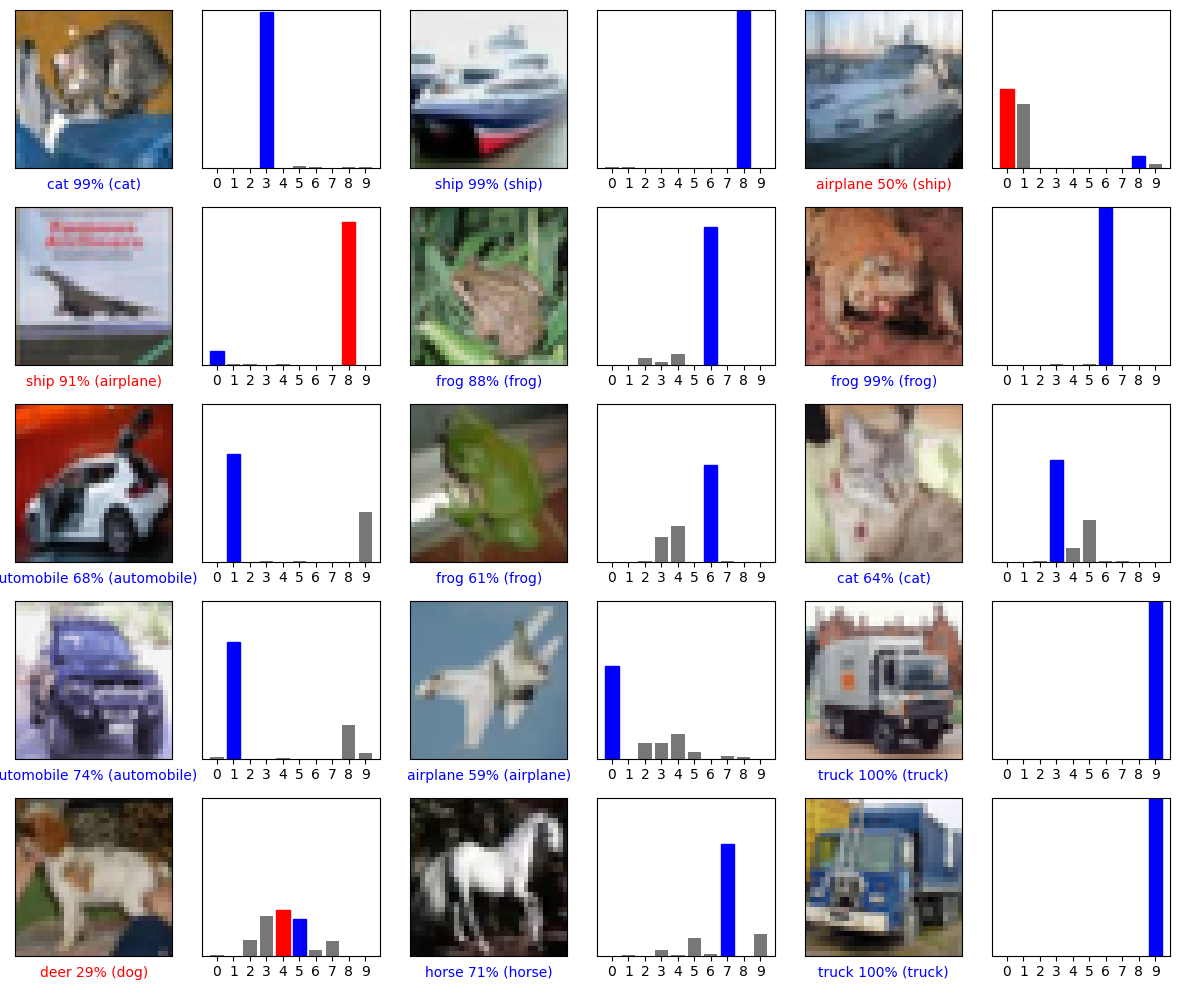

In [22]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

In [23]:
import pandas as pd
classss = pd.DataFrame({
    'classes' : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',\
         'frog', 'horse', 'ship', 'truck'],
})
classss

,classes
0,airplane
1,automobile
2,bird
3,cat
4,deer
5,dog
6,frog
7,horse
8,ship
9,truck
